# `prachathai-67k` Dataset

This notebook performs a preliminary exploration of the `prachathai-67k` dataset which was scraped from the news site [Prachathai](https://prachatai.com/). We filtered out those articles with less than 500 characters of body text, mostly images and cartoons. It contains 67,889 articles wtih 51,797 tags from August 24, 2004 to November 15, 2018. The dataset was originally scraped by [@lukkiddd](https://github.com/lukkiddd) and cleaned by [@cstorm125](https://github.com/cstorm125).

This dataset is a part of [pyThaiNLP](https://github.com/PyThaiNLP/) Thai text [classification-benchmarks](https://github.com/PyThaiNLP/classification-benchmarks). For the benchmark, we selected the following tags with substantial volume that resemble **classifying types of articles**$^+$:

* `การเมือง` - politics
* `สิทธิมนุษยชน` - human rights
* `คุณภาพชีวิต` - quality of life
* `ต่างประเทศ` - international
* `สังคม` - social
* `สิ่งแวดล้อม` - environment
* `เศรษฐกิจ` - economics
* `วัฒนธรรม` - culture
* `แรงงาน` - labor
* `ความมั่นคง` - national security
* `ไอซีที` - ICT
* `การศึกษา` - education

This is a **multi-label classification task** and we use **F1-score** for each label as the benchmark. The benchmark include both **title classification** and **body classification**.

$^+$ Note that Prachathai.com is a left-leaning, human-right-focused news site, and thus unusual news labels such as human rights and quality of life.

In [1]:
%%capture
%pip install pythainlp emoji

In [2]:
# Download dataset by uncommenting the lines below

# !wget -O prachathai-67k.zip https://www.dropbox.com/s/fsxepdka4l2pr45/prachathai-67k.zip?dl=1
# !unzip -y prachathai-67k.zip

In [3]:
import pandas as pd
import numpy as np
from pythainlp.tokenize import THAI2FIT_TOKENIZER
from ast import literal_eval
from tqdm import tqdm
from collections import Counter

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# !wget -O thsarabunnew-webfont.ttf https://github.com/PyThaiNLP/prachathai-67k/raw/master/thsarabunnew-webfont.ttf

fm.fontManager.addfont("thsarabunnew-webfont.ttf")
plt.rc('font', family='TH Sarabun New')

In [5]:
prachathai = pd.read_csv('prachathai-67k.csv')
print(prachathai.shape)
prachathai.head()

(67889, 5)


,url,date,title,body_text,labels
0,https://prachatai.com/print/42,2004-08-24 14:31,"นักวิจัยหนุน ""แม้ว"" เปิด ""จีเอ็มโอ""",ประชาไท --- 23 ส.ค.2547 นักวิจัยฯ ชี้นโยบายจี...,"['ข่าว', 'สิ่งแวดล้อม']"
1,https://prachatai.com/print/41,2004-08-24 14:22,ภาคประชาชนต้านเปิดเสรีจีเอ็มโอ,ประชาไท- 23 ส.ค.2547 นักวิชาการ ภาคประชาชน จ...,"['ข่าว', 'สิ่งแวดล้อม']"
2,https://prachatai.com/print/43,2004-08-24 15:17,จุฬาฯ ห่วงจีเอ็มโอลามข้าวไทย,นโยบายที่อนุญาตให้ปลูกร่วมกับพืชอื่นได้นั้นถื...,"['ข่าว', 'สิ่งแวดล้อม']"
3,https://prachatai.com/print/45,2004-08-24 15:58,ฟองสบู่การเมืองแตก ทักษิณหมดกึ๋น ชนชั้นกลางหมด...,ประชาไท -- 23 ส.ค. 47 ขาประจำทักษิณ ฟันธง ฟอง...,"['ข่าว', 'การเมือง', 'คณะเศรษฐศาสตร์ มหาวิทยาล..."
4,https://prachatai.com/print/47,2004-08-24 16:10,กอต.เสนอเลิกถนนคลองลาน-อุ้มผาง,ประชาไท-23 ส.ค.47 คณะกรรมการอนุรักษ์ ผืนป่าตะ...,"['ข่าว', 'สิ่งแวดล้อม']"


In [6]:
#text processor
import re, emoji,string
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    res = ''.join([char for char in res if char not in string.punctuation])
    
    #tokenize
    res = [word for word in THAI2FIT_TOKENIZER.word_tokenize(res) if word and not re.search(pattern=r"\s+", string=word)]

    #post rules
    res = ungroup_emoji(res)

    return res

## Labels

### Tag Distribution

In [7]:
all_labels = []
for i in tqdm(range(prachathai.shape[0])):
    all_labels+=literal_eval(prachathai.labels[i])

100%|██████████| 67889/67889 [00:01<00:00, 46067.55it/s]


In [8]:
label_df = pd.DataFrame.from_dict(dict(Counter(all_labels)),orient='index').reset_index()
label_df.columns = ['label','cnt']
label_df.sort_values('cnt',ascending=False,inplace=True)
print(label_df.shape)
label_df.head(15)

(51797, 2)


,label,cnt
0,ข่าว,53448
2,การเมือง,39124
62,สิทธิมนุษยชน,15067
42,คุณภาพชีวิต,11316
17,บทความ,9571
18,ต่างประเทศ,8114
43,สังคม,7893
1,สิ่งแวดล้อม,7703
19,เศรษฐกิจ,5008
135,วัฒนธรรม,4070


In [9]:
label_df.tail(10)

,label,cnt
23843,สุธน เลิศวิทยะ,1
23845,กลุ่ม New Culture,1
23846,ระวิจิตร สุวรรณบุปผา,1
23847,อูกันดา,1
23857,คำสั่งหยุดงาน,1
23858,การคืนอำนาจ,1
23865,อัคนี มูลเมฆ,1
23866,ณภัค เสรีรักษ์,1
23867,พุทธพล มงคลวรรณ,1
23841,Public Lecture,1


### Benchmark Labels

Out of over 50,000 tags, we selected 12 tags as our **benchmark labels**.

In [10]:
benchmark_labels = ['การเมือง','สิทธิมนุษยชน','คุณภาพชีวิต','ต่างประเทศ','สังคม',
                  'สิ่งแวดล้อม','เศรษฐกิจ','วัฒนธรรม','แรงงาน','ความมั่นคง',
                  'ไอซีที','การศึกษา']

def in_benchmark(x,label):
    res = 1 if label in literal_eval(x) else 0
    return(res)

In [11]:
for label in tqdm(benchmark_labels):
    prachathai[label] = prachathai.labels.map(lambda x: in_benchmark(x,label))

100%|██████████| 12/12 [00:11<00:00,  1.00it/s]


### Number of Labels Per Sample

In [12]:
corr_df = prachathai.iloc[:,5:]

label_cnt = corr_df.sum(axis=1)
label_cnt_df = pd.DataFrame.from_dict(dict(Counter(label_cnt)), orient='index').reset_index()
label_cnt_df.columns = ['nb_label','cnt']
label_cnt_df = label_cnt_df.sort_values('cnt',ascending=False)
label_cnt_df['per'] = label_cnt_df.cnt / label_cnt_df.cnt.sum()

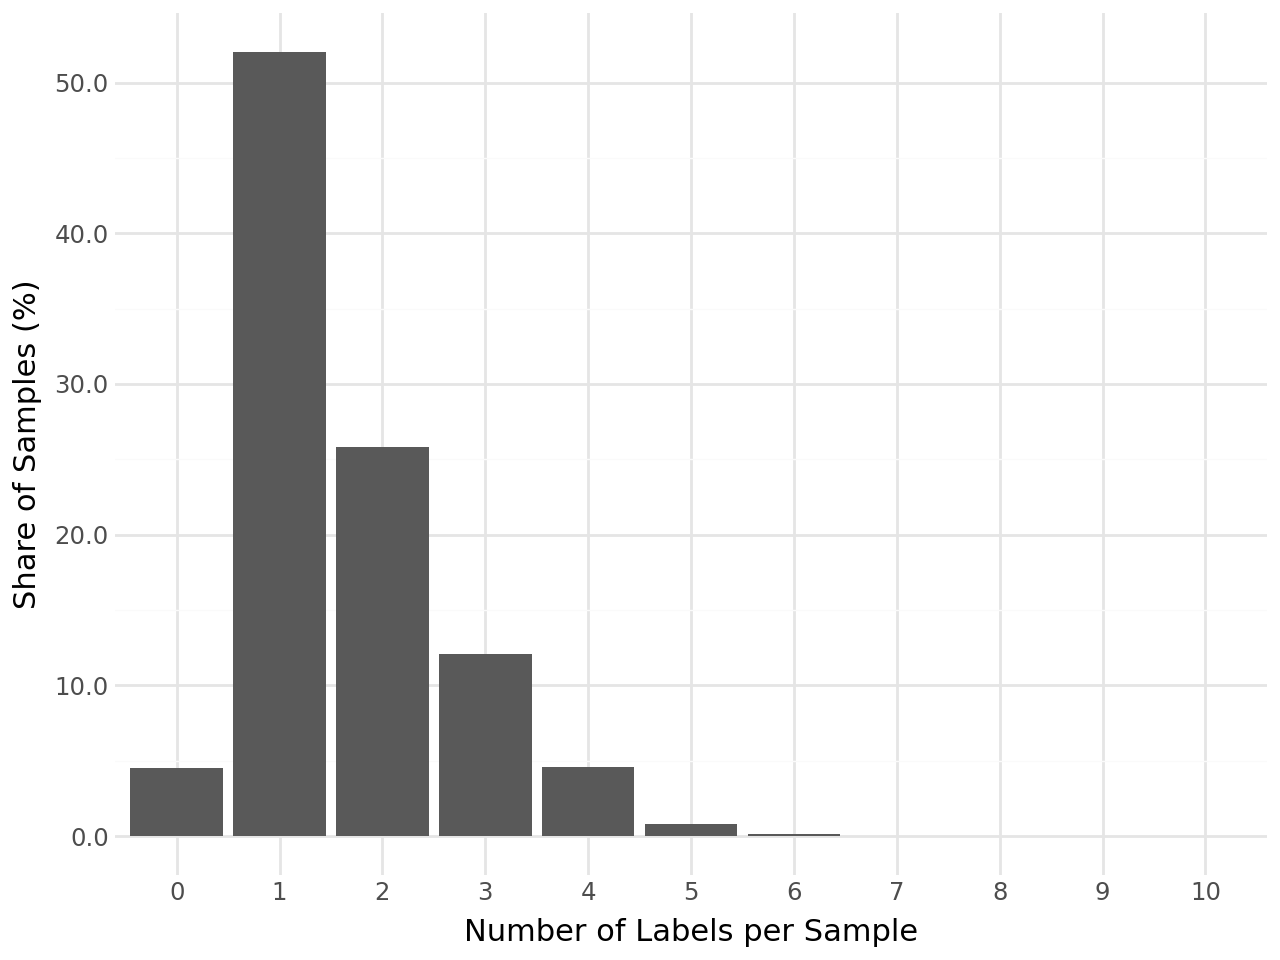

,nb_label,cnt,per
0,1,35320,0.520261
2,2,17527,0.258171
3,3,8193,0.120682
4,4,3124,0.046016
1,0,3078,0.045339
5,5,537,0.007910
6,6,82,0.001208
9,7,12,0.000177
7,8,8,0.000118
8,9,6,0.000088


In [13]:
g = (ggplot(label_cnt_df,aes(x='factor(nb_label)', y='per')) + geom_bar(stat='identity') +
    theme_minimal() + scale_y_continuous(labels = lambda x: np.round(np.array(x)*100,0)) +
    xlab('Number of Labels per Sample') + ylab('Share of Samples (%)'))
display(g)
label_cnt_df

### Benchmark Label Distribution

In [14]:
with pd.option_context('display.min_rows', 60, 'display.max_rows', 60):
    display(label_df)

,label,cnt
0,ข่าว,53448
2,การเมือง,39124
62,สิทธิมนุษยชน,15067
42,คุณภาพชีวิต,11316
17,บทความ,9571
18,ต่างประเทศ,8114
43,สังคม,7893
1,สิ่งแวดล้อม,7703
19,เศรษฐกิจ,5008
135,วัฒนธรรม,4070


In [15]:
label_df = corr_df.sum(axis=0).reset_index()
label_df.columns = ['label','cnt']
label_df['per'] = label_df.cnt / label_df.cnt.sum()
label_df.sort_values('per',ascending=False,inplace=True)
label_df['en_label'] = ['00 - politics','01 - human_rights','02 - quality_of_life','03 - international',
                        '04 -social','05 - environment','06 - economics','07 - culture','08 - labor',
                        '09 - national_security','10 - ICT',
                       '11 - education']

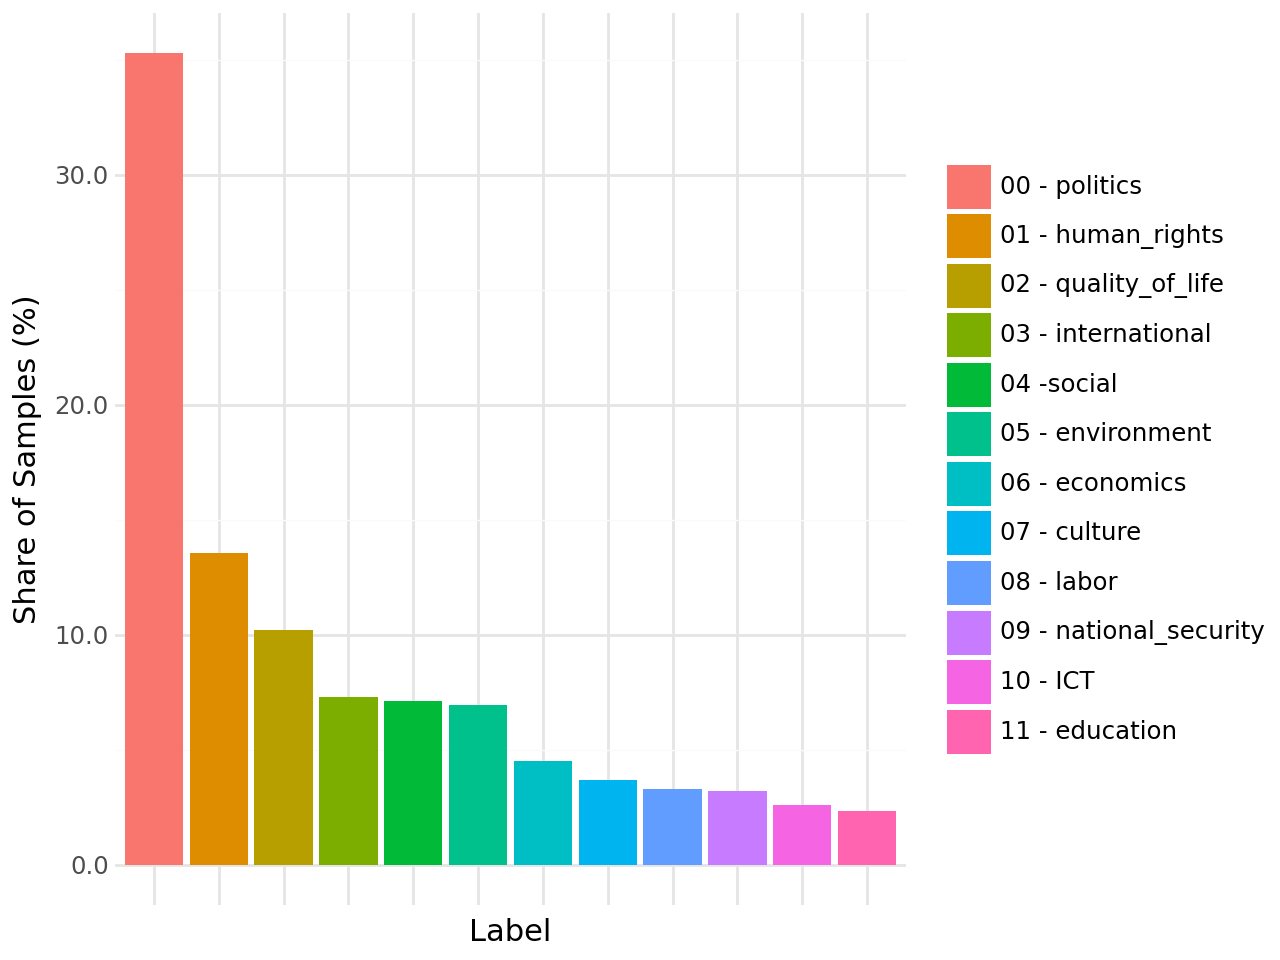

,label,cnt,per,en_label
0,การเมือง,39095,0.352690,00 - politics
1,สิทธิมนุษยชน,15030,0.135591,01 - human_rights
2,คุณภาพชีวิต,11308,0.102014,02 - quality_of_life
3,ต่างประเทศ,8094,0.073019,03 - international
4,สังคม,7892,0.071197,04 -social
5,สิ่งแวดล้อม,7693,0.069401,05 - environment
6,เศรษฐกิจ,5000,0.045107,06 - economics
7,วัฒนธรรม,4065,0.036672,07 - culture
8,แรงงาน,3630,0.032748,08 - labor
9,ความมั่นคง,3542,0.031954,09 - national_security


In [16]:
g = (ggplot(label_df,aes(x='en_label', y='per', fill='en_label')) + geom_bar(stat='identity') +
    theme_minimal() + scale_y_continuous(labels = lambda x: np.round(np.array(x)*100,0)) +
    xlab('Label') + ylab('Share of Samples (%)') +
    theme(axis_text_x = element_blank(),legend_title=element_blank()))
display(g)
label_df

### Label Correlation

In [17]:
corr_df.columns = label_df.en_label

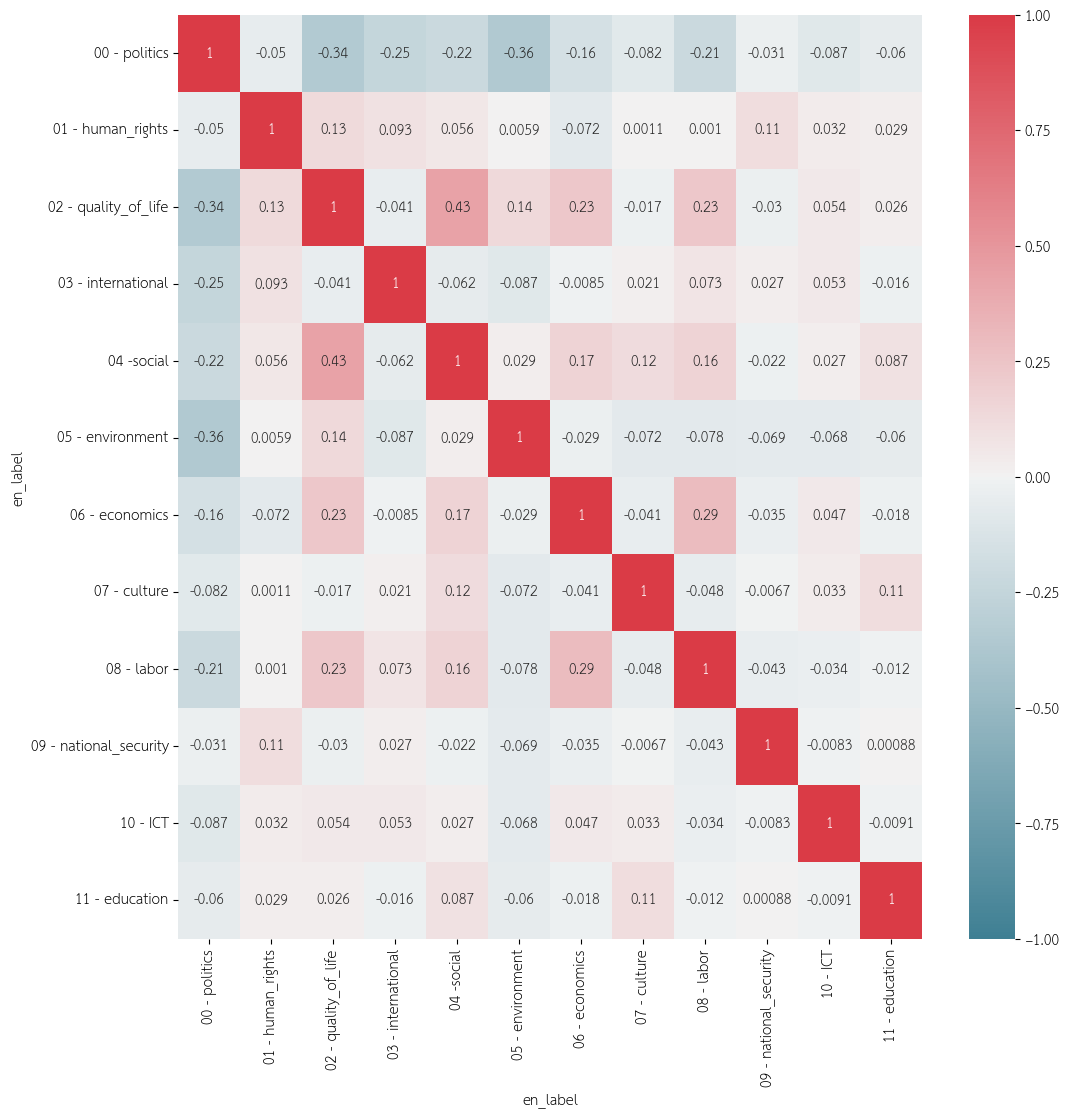

In [18]:
plt.figure(figsize=(12,12))
corr = corr_df.corr(method='pearson')
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1, vmax=1, annot=True)
plt.show()

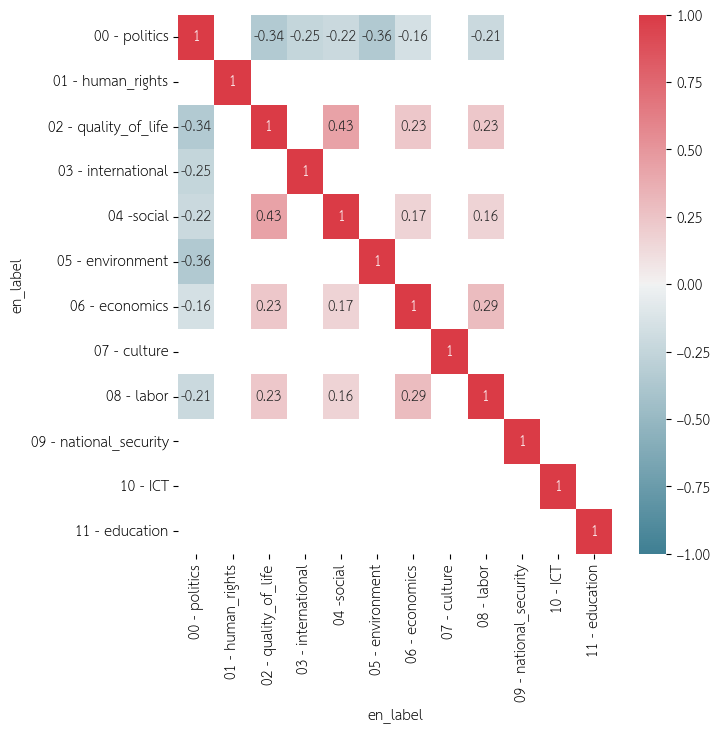

In [19]:
plt.figure(figsize=(7,7))
corr = corr_df.corr(method='pearson')
sns.heatmap(corr[(corr>0.15) | (corr<-0.15)], cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1, vmax=1, annot=True)
plt.show()


## Title

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

title_cnt = CountVectorizer(tokenizer=THAI2FIT_TOKENIZER.word_tokenize, token_pattern=None)
title_mat = title_cnt.fit_transform(prachathai.title)

### Title Word Count Distribution

In [21]:
title_wc = pd.DataFrame(title_mat.sum(axis=1))
title_wc.columns = ['word_count']

Average Title Word Count: 15.362164710041391


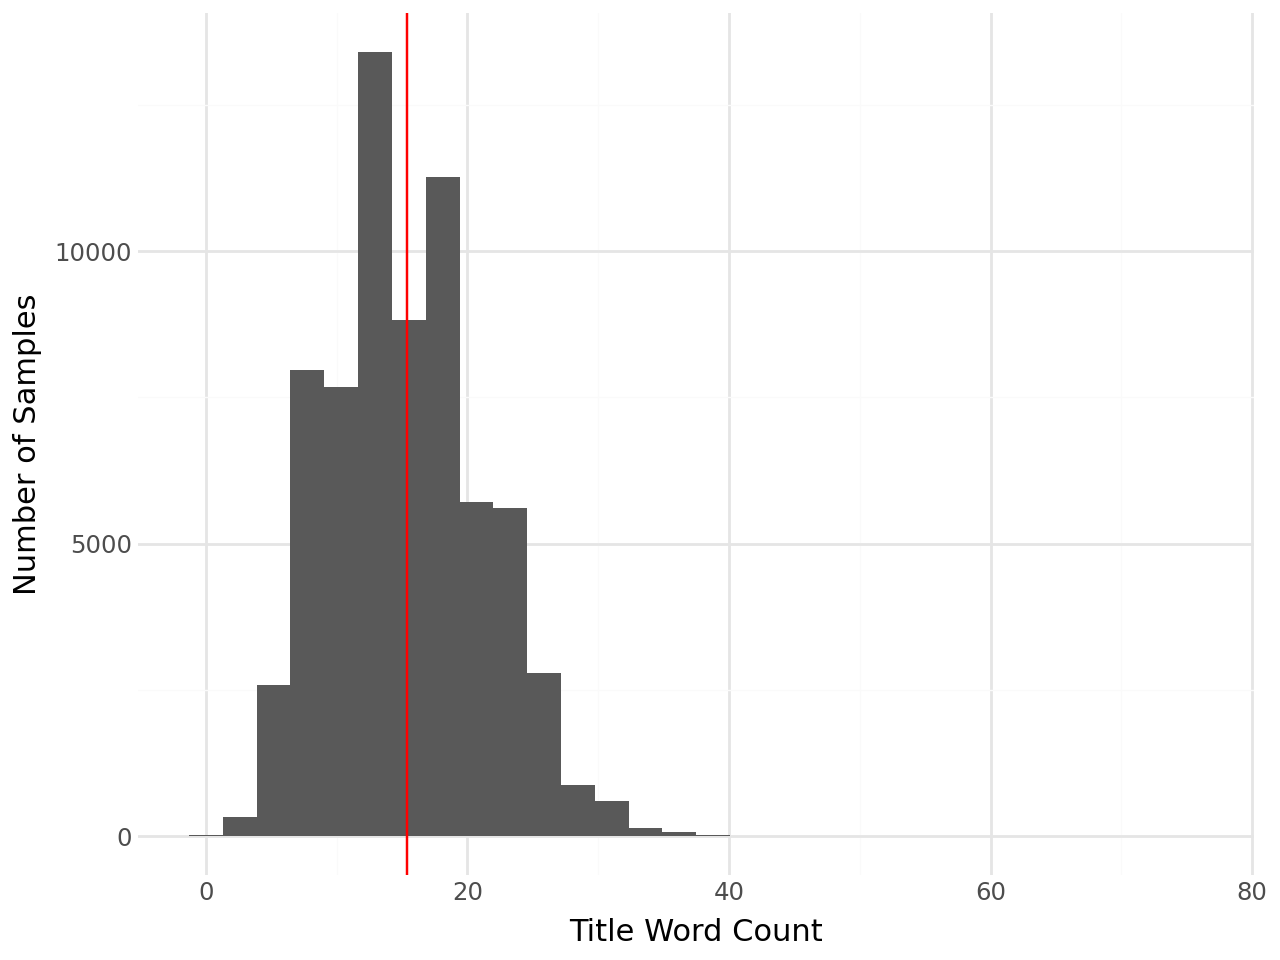

In [22]:
g = (ggplot(title_wc, aes(x='word_count')) + geom_histogram(bins=30) + theme_minimal() +
    xlab('Title Word Count') + ylab('Number of Samples') +
    geom_vline(xintercept = np.mean(title_wc.word_count), color='red'))
print(f'Average Title Word Count: {np.mean(title_wc.word_count)}')
g

### Title Word Frequency

In [23]:
title_top = pd.DataFrame({
    'vocab': list(title_cnt.get_feature_names_out()),
    'cnt': np.asarray(title_mat.sum(axis=0)).squeeze()}).sort_values('cnt',ascending=False)
title_top = title_top.reset_index(drop=True).reset_index()

In [24]:
title_top.head()

,index,vocab,cnt
0,0,,190410
1,1,"""",19866
2,2,',14812
3,3,-,12857
4,4,:,11910


Median Title Word Frequency: 1.0


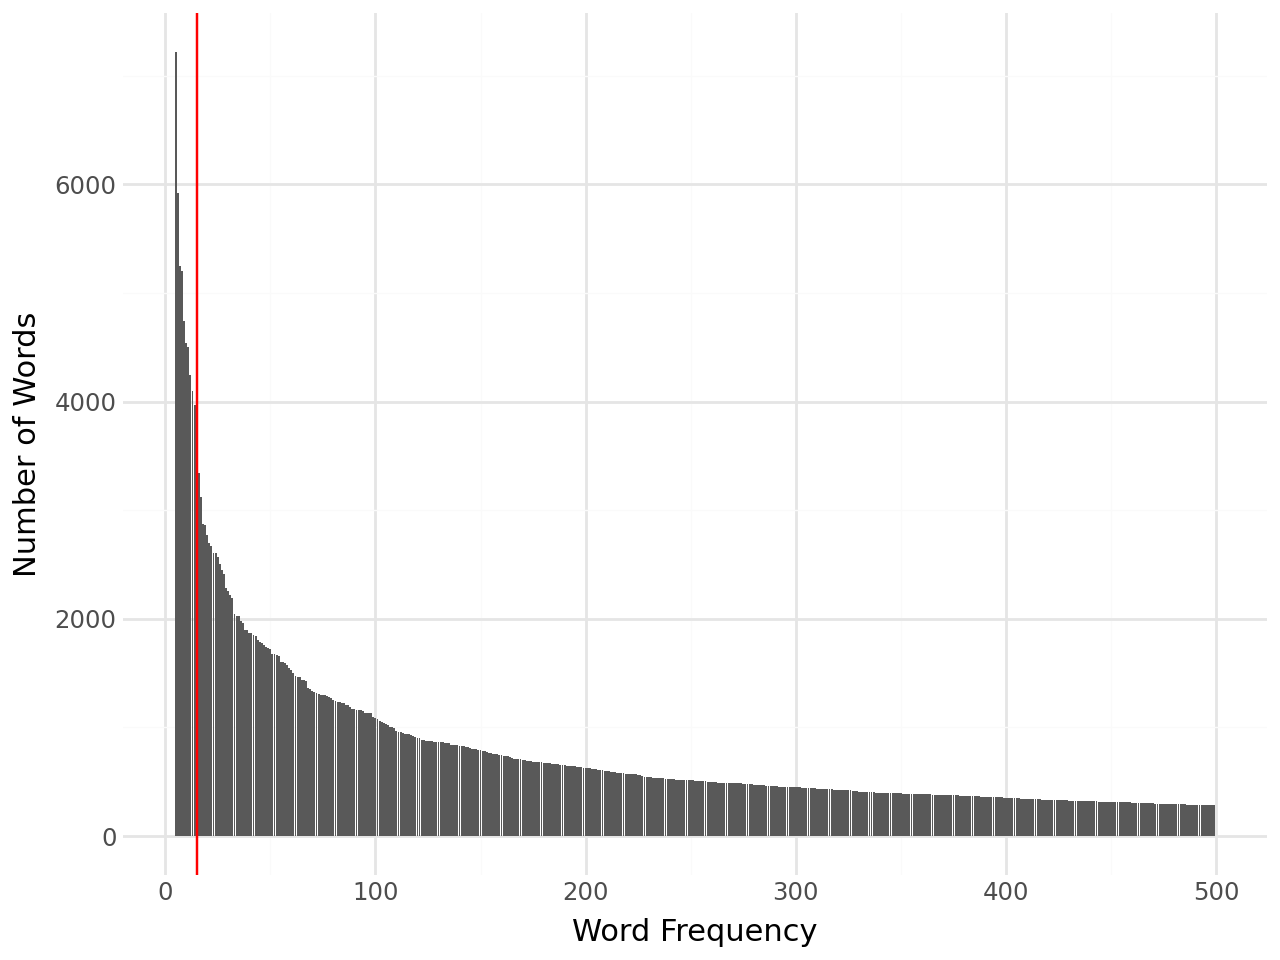

In [25]:
g = (ggplot(title_top.iloc[5:500,:], aes(x='index',y='cnt')) + geom_bar(stat='identity') + theme_minimal() +
    xlab('Word Frequency') + ylab('Number of Words') +
    geom_vline(xintercept = np.mean(title_wc.word_count), color='red'))
print(f'Median Title Word Frequency: {np.median(title_top.cnt)}')
g

In [26]:
title_top.head(10)

,index,vocab,cnt
0,0,,190410
1,1,"""",19866
2,2,',14812
3,3,-,12857
4,4,:,11910
5,5,ใน,7220
6,6,ไทย,5925
7,7,ที่,5251
8,8,ไม่,5205
9,9,ของ,4742


In [27]:
title_top.iloc[100:,:].head(10)

,index,vocab,cnt
100,100,ชุมชน,1085
101,101,ต้าน,1075
102,102,ไท,1063
103,103,เรื่อง,1053
104,104,ภาค,1039
105,105,ล้าน,1036
106,106,นี้,1026
107,107,แต่,1007
108,108,เข้า,1001
109,109,แก้,999


In [28]:
title_top.tail(10)

,index,vocab,cnt
44776,44776,นอนม็อบ,1
44777,44777,นอนมา,1
44778,44778,นอนบ้านอีกหลาย,1
44779,44779,นอนบ้าน,1
44780,44780,นอนทุกข์,1
44781,44781,นอนครบทั้ง,1
44782,44782,นอนกรง,1
44783,44783,นอกใจ,1
44784,44784,นอกเหนือจากอุตสาหกรรม,1
44785,44785,นอนอยู่,1


### Text Feature Correlations

In [29]:
label_df.label

0         การเมือง
1     สิทธิมนุษยชน
2      คุณภาพชีวิต
3       ต่างประเทศ
4            สังคม
5      สิ่งแวดล้อม
6         เศรษฐกิจ
7         วัฒนธรรม
8           แรงงาน
9       ความมั่นคง
10          ไอซีที
11        การศึกษา
Name: label, dtype: str

In [30]:
from class_features import *
from sklearn.feature_extraction.text import TfidfVectorizer

title_vec = TfidfVectorizer(analyzer=process_text)
title_tfidf_mat = title_vec.fit_transform(prachathai.title)
title_features = title_vec.get_feature_names_out()

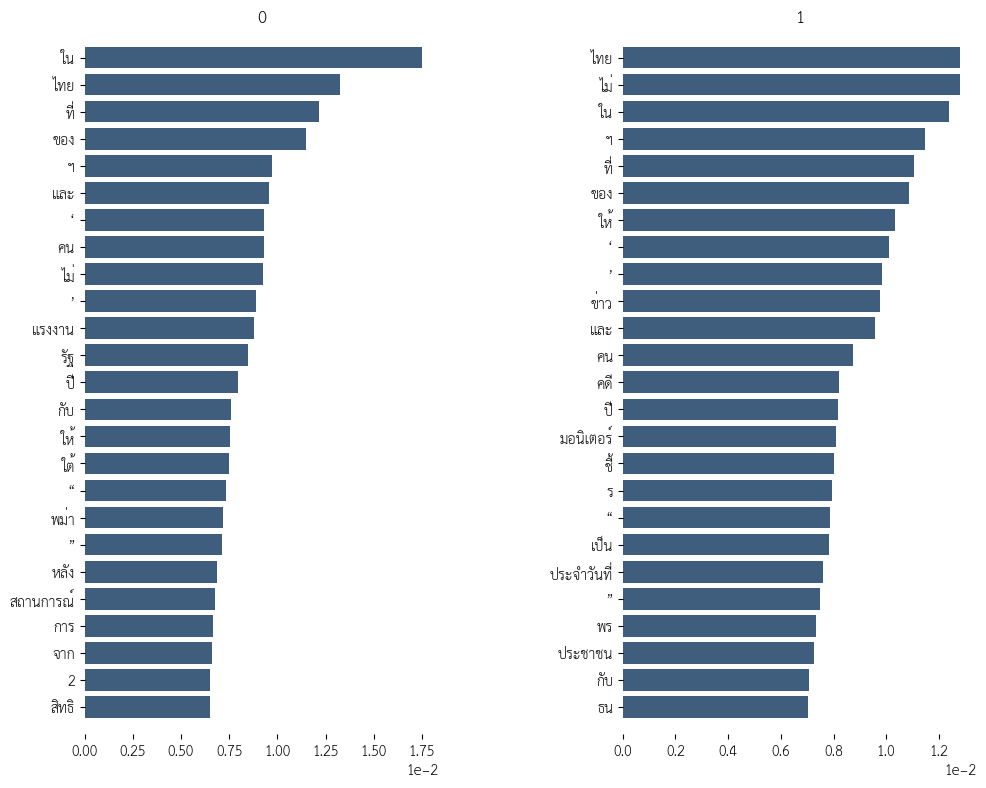

In [31]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='การเมือง'
)

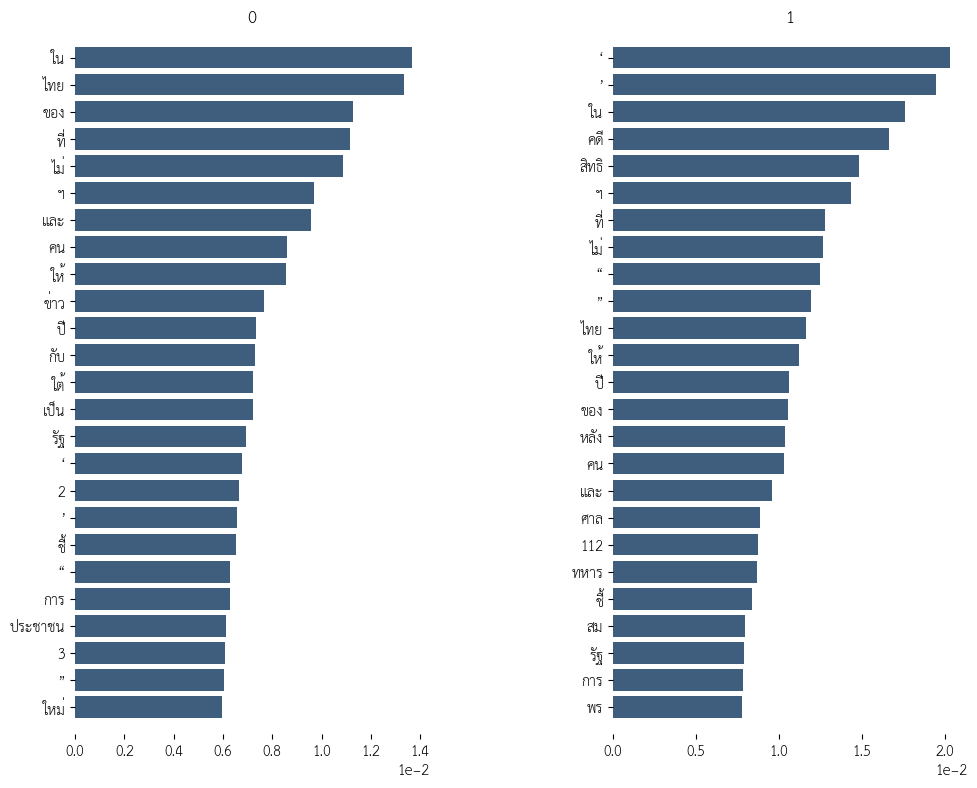

In [32]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='สิทธิมนุษยชน'
)

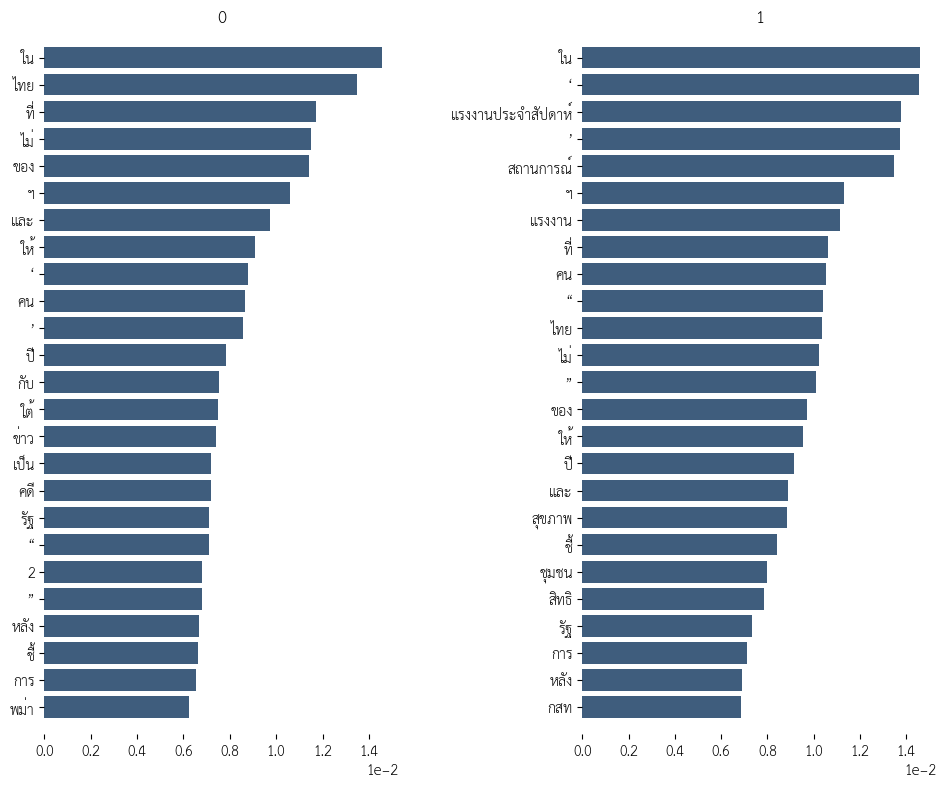

In [33]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='คุณภาพชีวิต'
)

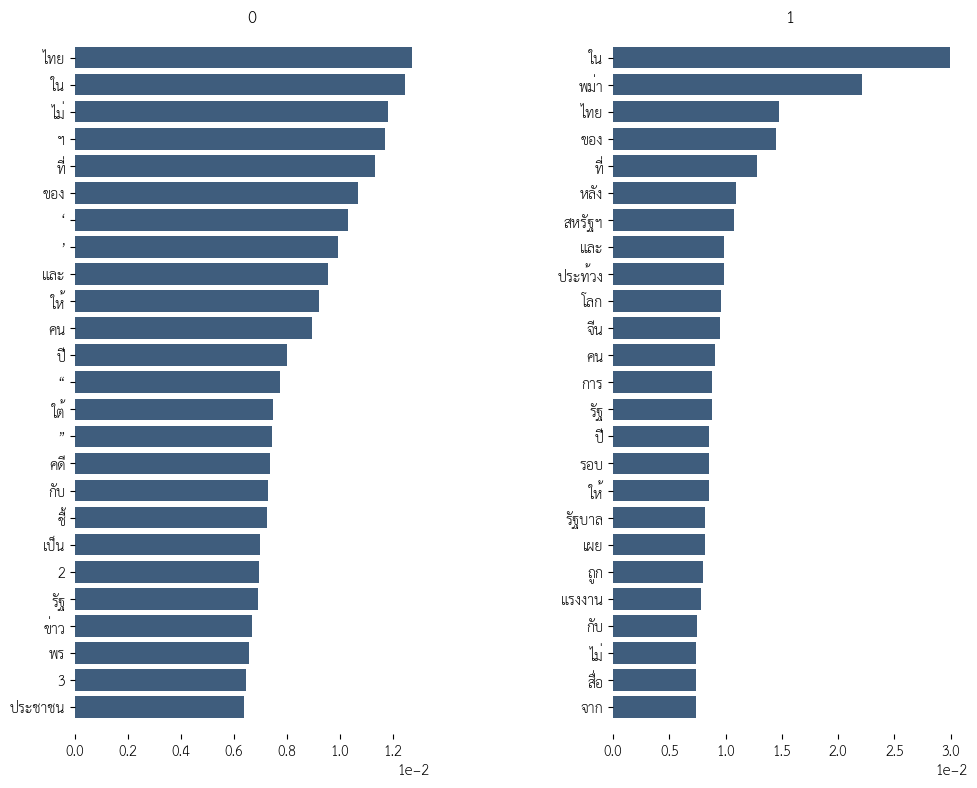

In [34]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='ต่างประเทศ'
)

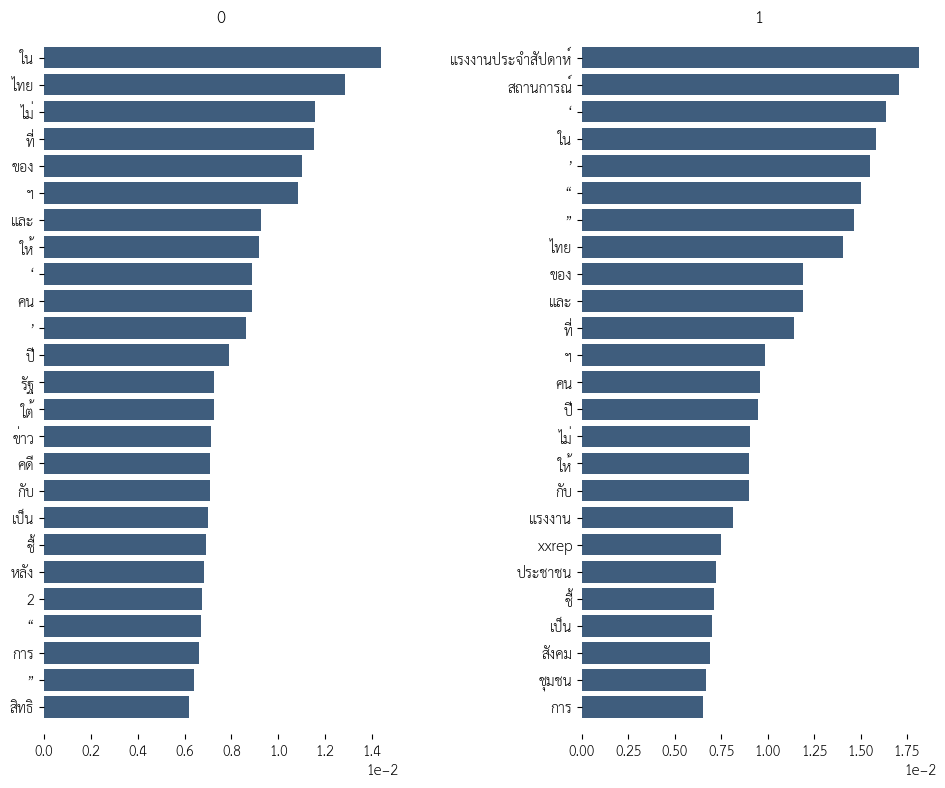

In [35]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='สังคม'
)

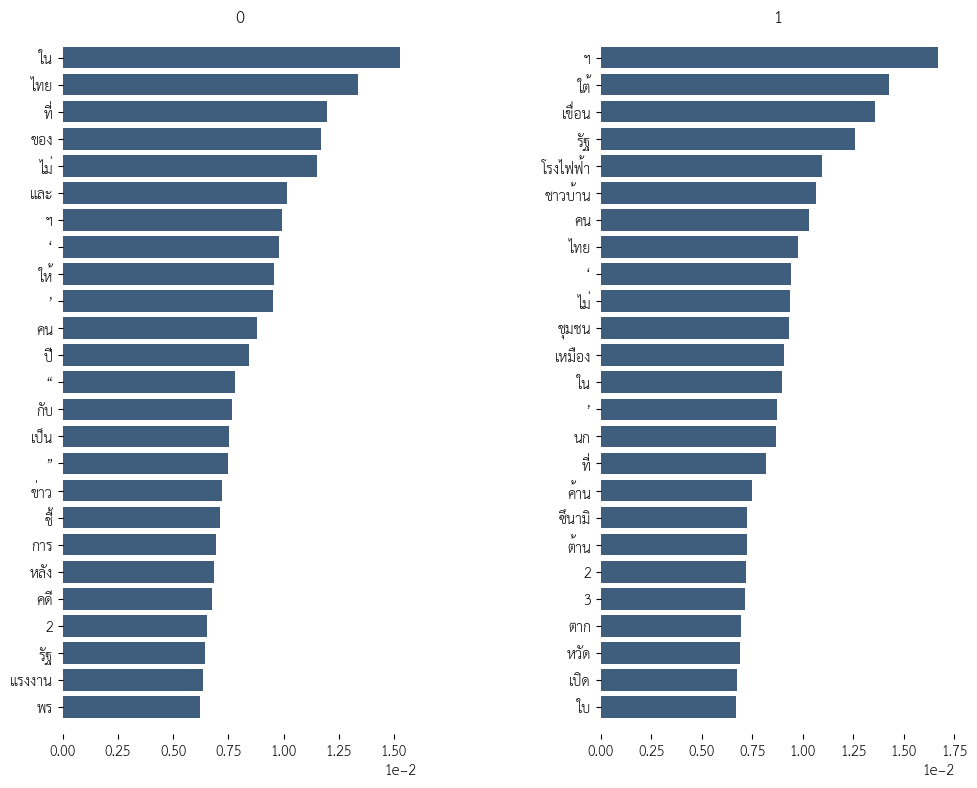

In [36]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='สิ่งแวดล้อม'
)

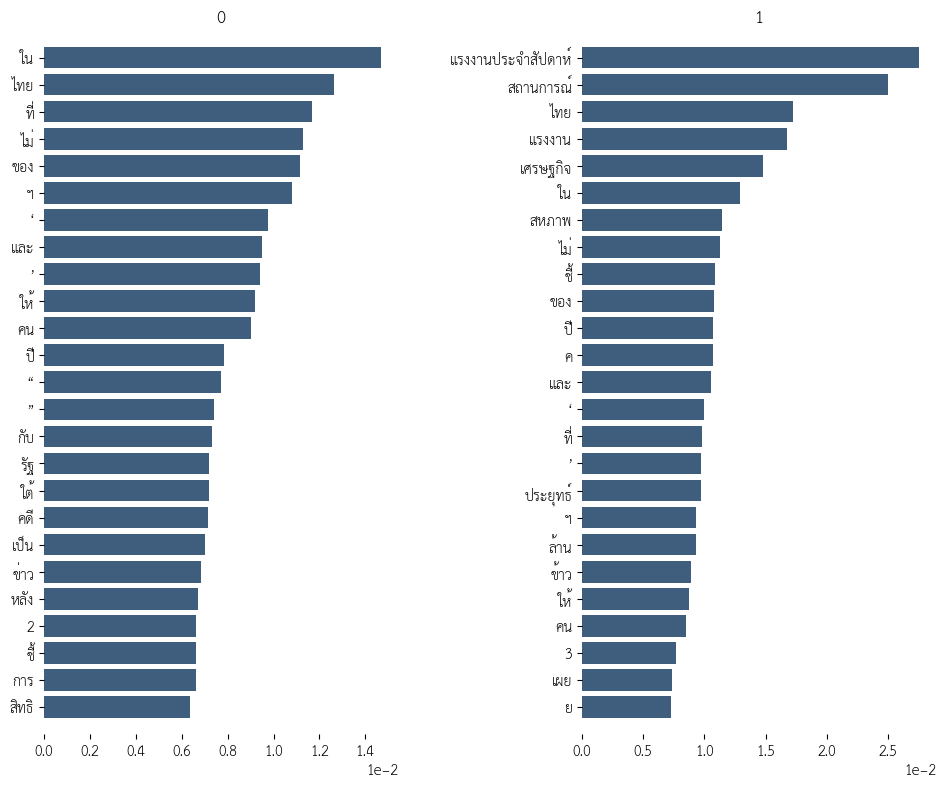

In [37]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='เศรษฐกิจ'
)

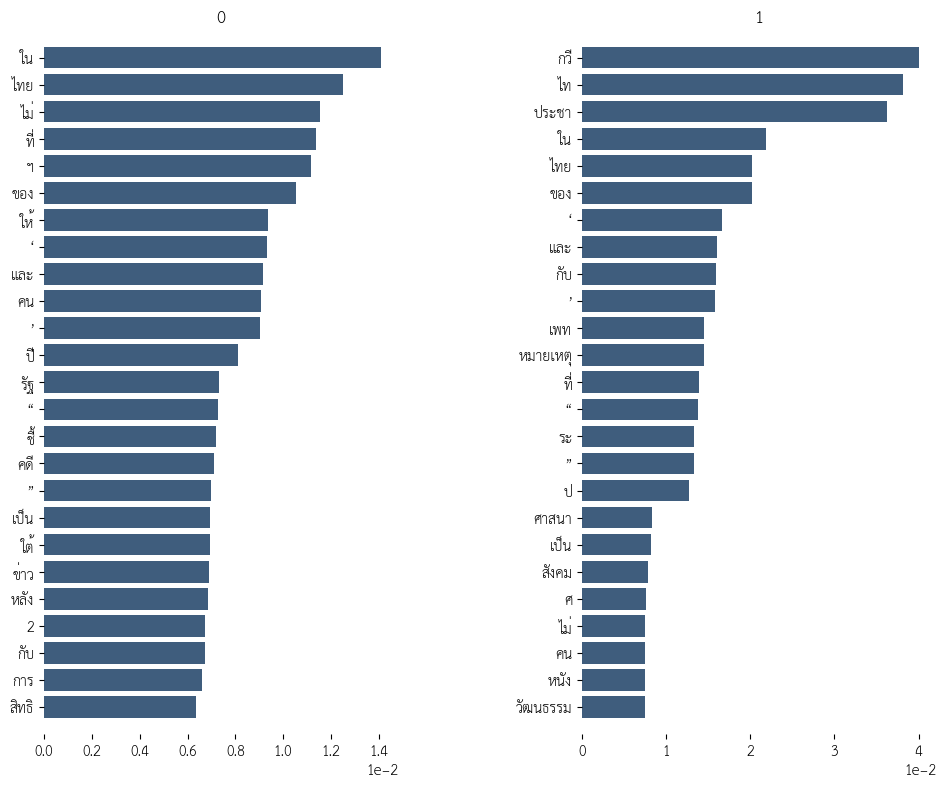

In [38]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='วัฒนธรรม'
)

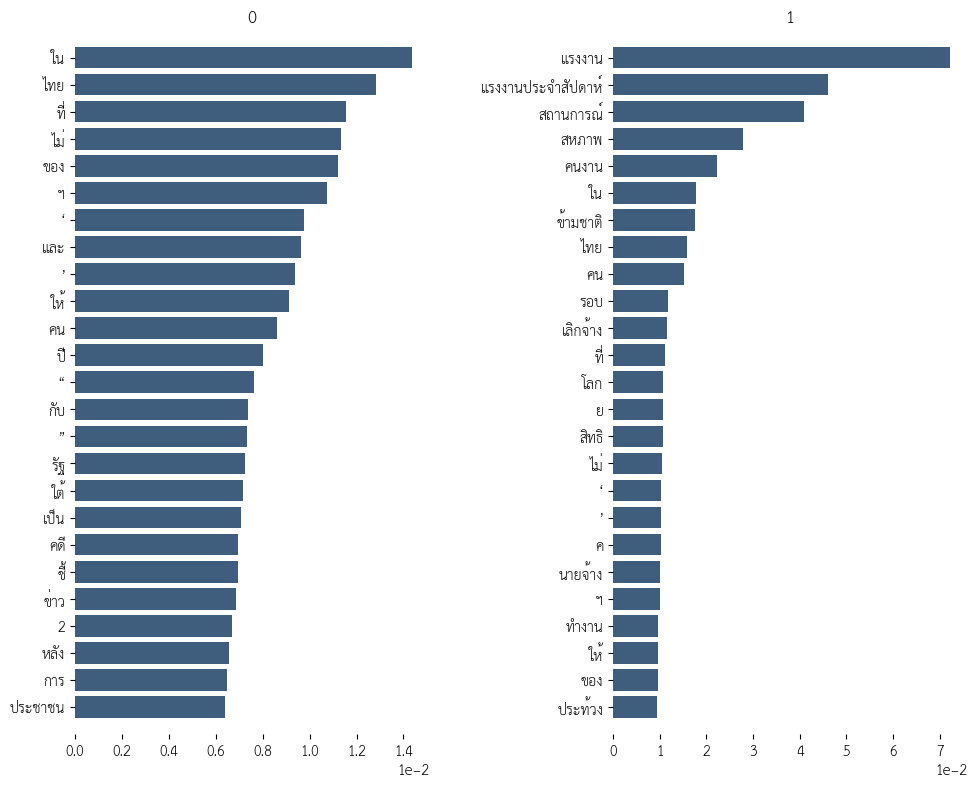

In [39]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='แรงงาน'
)

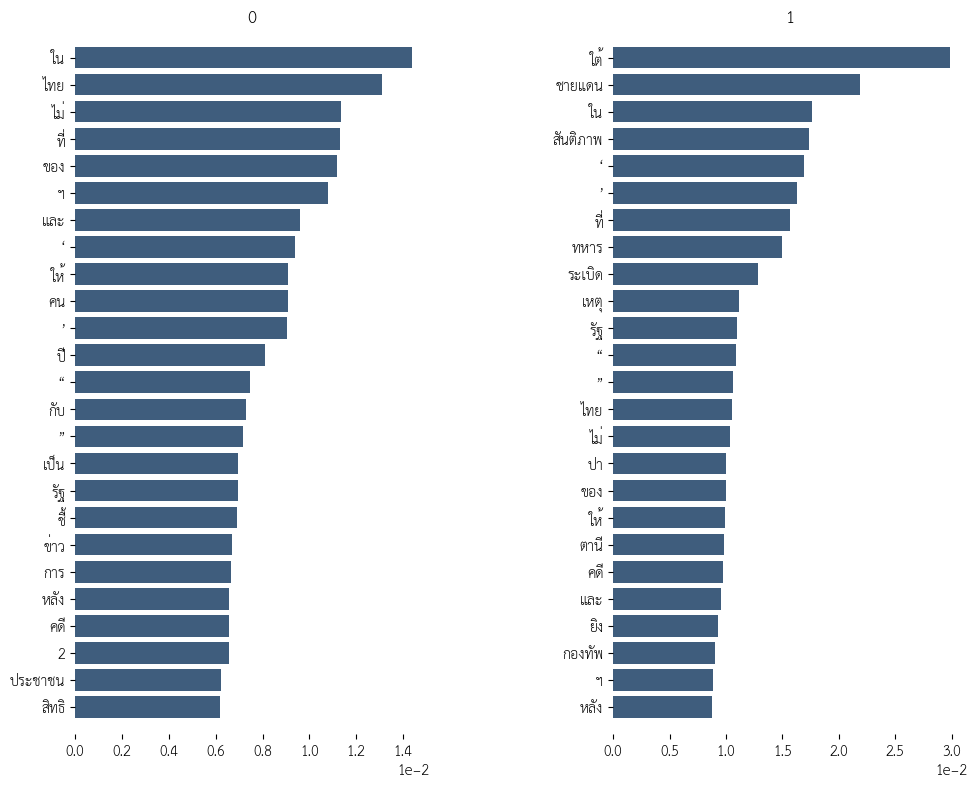

In [40]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='ความมั่นคง'
)

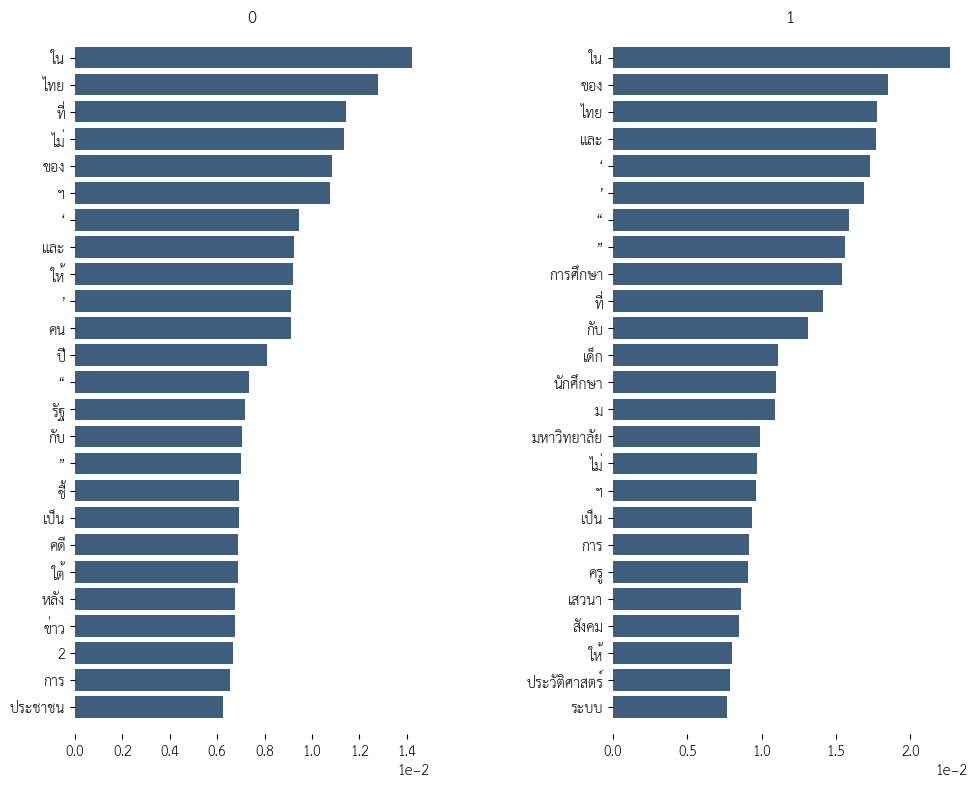

In [41]:
show_classfeats(
    df=prachathai,
    mat=title_tfidf_mat,
    features=title_features,
    class_col='การศึกษา'
)